In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import seaborn as sns

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from sklearn.metrics import f1_score

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
pretrained_vit_weights = torchvision.models.ViT_L_16_Weights.DEFAULT 

pretrained_vit = torchvision.models.vit_l_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
class_names = ['Epidural', 'Intraparenchymal', 'Intraventicular', 'Normal', 'Subarachnoid', 'Subdural']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)

In [4]:
from torchinfo import summary

summary(model=pretrained_vit, 
        input_size=(16, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

C:\Conda\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [16, 3, 224, 224]    [16, 6]              1,024                Partial
├─Conv2d (conv_proj)                                         [16, 3, 224, 224]    [16, 1024, 14, 14]   (787,456)            False
├─Encoder (encoder)                                          [16, 197, 1024]      [16, 197, 1024]      201,728              False
│    └─Dropout (dropout)                                     [16, 197, 1024]      [16, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [16, 197, 1024]      [16, 197, 1024]      --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [16, 197, 1024]      [16, 197, 1024]      (12,596,224)         False
│    │    └─EncoderBlock (encoder_layer_1)                   [16, 197, 1024]      [16, 

In [5]:
train_dir = './ich_dataset2-1/augmented/256/train/'
test_dir = './ich_dataset2-1/augmented/256/test/'

In [6]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=8) 

In [9]:
from going_modular.going_modular import engine

# default optimizer
# optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
#                              lr=1e-3)

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-2)

# optimizer = torch.optim.AdamW(params=pretrained_vit.parameters(), 
#                              lr=2e-5)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6557 | train_acc: 0.5548 | train_f1: 0.5548 | test_loss: 0.6939 | test_acc: 0.7490 | test_f1: 0.7497
Epoch: 2 | train_loss: 1.0587 | train_acc: 0.7012 | train_f1: 0.7011 | test_loss: 0.9329 | test_acc: 0.7162 | test_f1: 0.7199
Epoch: 3 | train_loss: 0.9348 | train_acc: 0.7539 | train_f1: 0.7538 | test_loss: 1.2241 | test_acc: 0.7218 | test_f1: 0.7183
Epoch: 4 | train_loss: 0.9235 | train_acc: 0.7664 | train_f1: 0.7662 | test_loss: 0.3752 | test_acc: 0.8826 | test_f1: 0.8834
Epoch: 5 | train_loss: 0.7922 | train_acc: 0.7941 | train_f1: 0.7939 | test_loss: 0.4577 | test_acc: 0.8725 | test_f1: 0.8728
Epoch: 6 | train_loss: 0.8571 | train_acc: 0.7956 | train_f1: 0.7958 | test_loss: 0.6790 | test_acc: 0.8382 | test_f1: 0.8350
Epoch: 7 | train_loss: 0.7303 | train_acc: 0.8239 | train_f1: 0.8240 | test_loss: 0.5966 | test_acc: 0.8508 | test_f1: 0.8522
Epoch: 8 | train_loss: 0.7024 | train_acc: 0.8297 | train_f1: 0.8296 | test_loss: 0.4286 | test_acc: 0.8836 | test_f1:

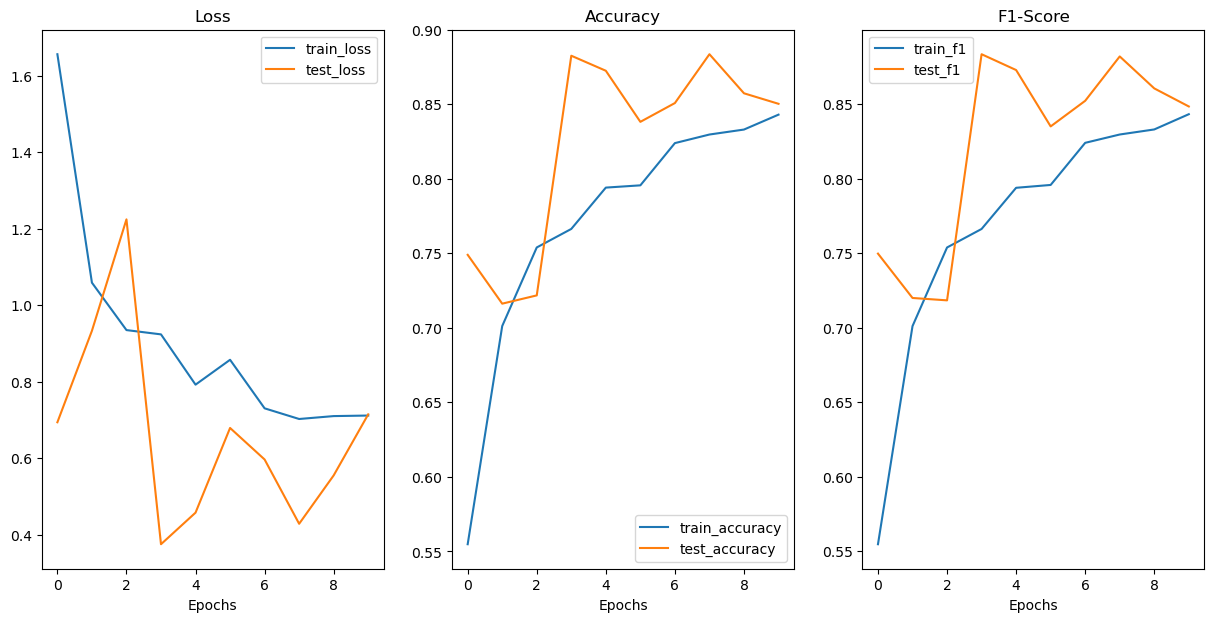

In [10]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

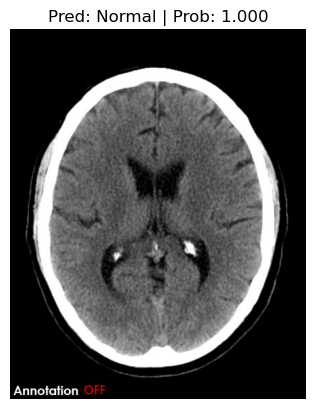

In [11]:
import requests
import torch
import torchvision
from torch import nn
from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "normal1.jpg"
model_name = "model.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_file = torchvision.models.vit_l_16().to(device)
class_names = ['Epidural', 'Intraparenchymal', 'Intraventicular', 'Normal', 'Subarachnoid', 'Subdural']
model_file.heads = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)
model_file.load_state_dict(torch.load(f"models/{model_name}"))

# pred_and_plot_image(model=pretrained_vit,
#                     image_path=custom_image_path,
#                     class_names=class_names)

pred_and_plot_image(model=model_file,
                    image_path=custom_image_path,
                    class_names=class_names)

In [12]:
import requests
import torch
import torchvision
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

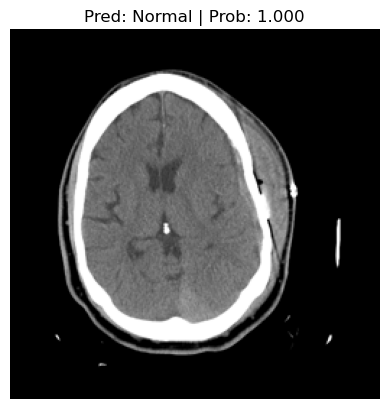

In [13]:
custom_image_path = "subdural.png"

pred_and_plot_image(model=model_file,
                    image_path=custom_image_path,
                    class_names=class_names)

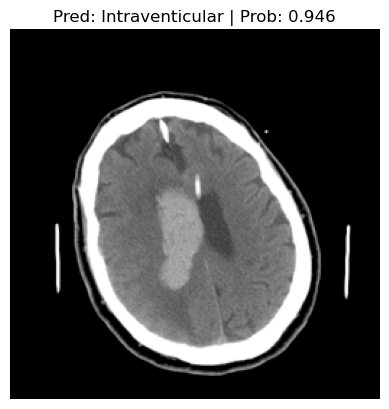

In [14]:
custom_image_path = "intraventicular.png"

pred_and_plot_image(model=model_file,
                    image_path=custom_image_path,
                    class_names=class_names)

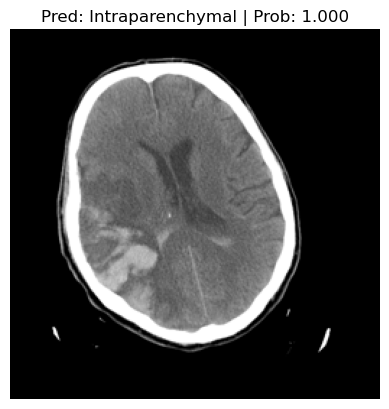

In [15]:
custom_image_path = "subarachnoid.png"

pred_and_plot_image(model=model_file,
                    image_path=custom_image_path,
                    class_names=class_names)

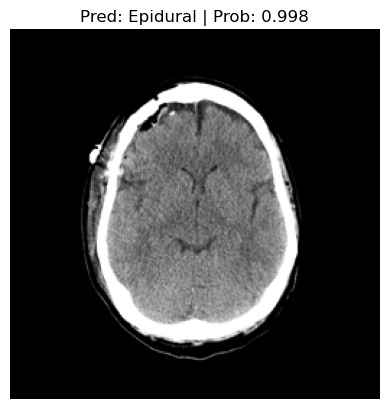

In [16]:
custom_image_path = "epidural.png"

pred_and_plot_image(model=model_file,
                    image_path=custom_image_path,
                    class_names=class_names)

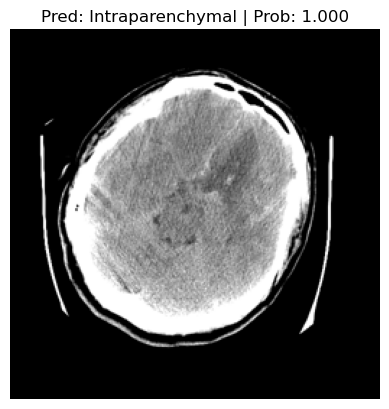

In [17]:
custom_image_path = "intraparenchymal.png"

pred_and_plot_image(model=model_file,
                    image_path=custom_image_path,
                    class_names=class_names)

In [18]:
!python --version

Python 3.11.5


In [19]:
torch.__version__

'2.2.1'

In [20]:
torch.cuda.is_available()

True

In [21]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [22]:
torch.cuda.device_count()

1

In [23]:
torch.cuda.current_device()

0

In [24]:
torch.cuda.device(0)